In [21]:
#preprocessing as previous
import pandas as pd
df = pd.read_csv('NFLX.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.insert(1, 'Day_Name', df['Date'].apply(lambda x: x.dayofweek + 1))
df.isnull().sum()

Date         0
Day_Name     0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [22]:
print("Starting date: ",df.iloc[0][0])
print("Ending date: ", df.iloc[-1][0])
print("Duration: ", df.iloc[-1][0]-df.iloc[0][0])

Starting date:  2018-02-05 00:00:00
Ending date:  2022-02-04 00:00:00
Duration:  1460 days 00:00:00


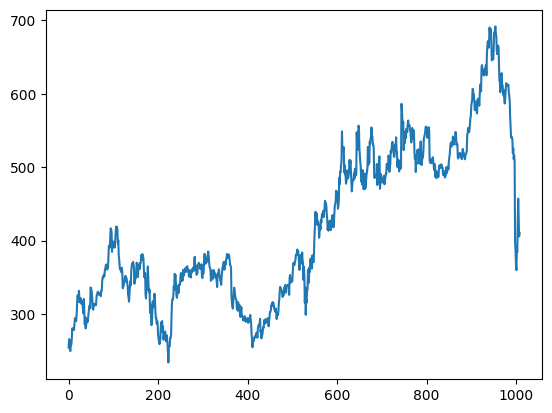

In [37]:
import matplotlib.pyplot as plt

dfclose =df[['Date', 'Close']]
#dfclose.shape #1009 records
# dfclose = dfclose[dfclose['Date']>'2021-02-04'] #considering only the data during a year
# #dfclose.shape #253 records

plt.plot(df.index, dfclose['Close'])

In [24]:
from sklearn.preprocessing import MinMaxScaler

dfclose = dfclose.drop(['Date'], axis =1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dfclose)
dfclose_scaled = scaler.transform(dfclose)

#dfclose.shape

In [25]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dfclose_scaled, train_size = 0.9, random_state = 0)
#train_set.shape #(202,1)

In [26]:
import numpy as np

def create_sets(set, step = 1):
    X, y = [], []
    for i in range(len(set) - step):
        X.append(set[i:(i+step), 0])
        y.append(set[i+step, 0])
    return np.array(X), np.array(y)

In [27]:
X_train, y_train = create_sets(train_set, 10)
X_test, y_test = create_sets(test_set, 10)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (797, 10)
y_train:  (797,)
X_test:  (192, 10)
y_test (192,)


In [28]:
#reshape for gru model ([close_prices, time step, featues])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
#X_train.shape #(192,10,1)

In [29]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(50, return_sequences =True, input_shape = (10,1)))
model.add(tf.keras.layers.GRU(50, return_sequences =True))
model.add(tf.keras.layers.GRU(50))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 10, 50)            7950      
                                                                 
 gru_4 (GRU)                 (None, 10, 50)            15300     
                                                                 
 gru_5 (GRU)                 (None, 50)                15300     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38,601
Trainable params: 38,601
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(X_train, y_train, epochs =100, batch_size =32, verbose =1)

Epoch 1/100
25/25 [==============================] - 3s 7ms/step - loss: 0.0803
Epoch 2/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0592
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0588
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0590
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0582
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0572
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0581
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0573
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0569
Epoch 10/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0567
Epoch 11/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0568
Epoch 12/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0568
Epoch 13/100
25/25 [=================

In [32]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

25/25 [==============================] - 1s 3ms/step


In [33]:
y_test_pred.shape, 
y_train_pred.shape

((192, 1), (797, 1))

In [34]:
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1,1))
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1,1))
#y_test_pred

In [35]:
from sklearn.metrics import mean_squared_error

MSE1 = mean_squared_error(y_test_inverse, y_test_pred)

MSE2 = mean_squared_error(y_train_inverse, y_train_pred)
MSE1, MSE2

(11457.25648378612, 11681.152623485965)

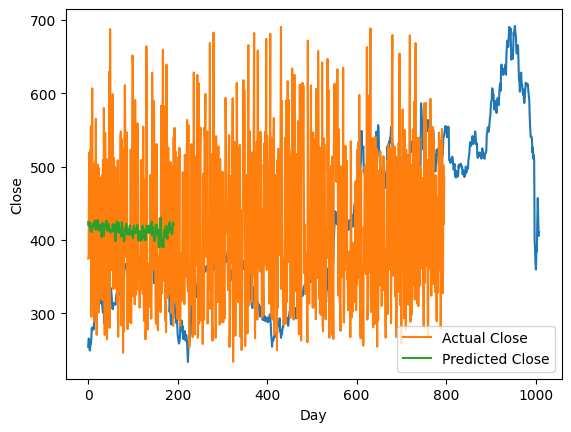

In [38]:
import matplotlib.pyplot as plt
plt.plot(dfclose['Close'])
plt.plot(y_train_inverse, label='Actual Close')
plt.plot(y_test_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()